<span style="font-family:Papyrus; font-size:3em;" >Estimating Parameter Confidence Intervals With Bootstrapping</span>

This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Construct the confidence interval

# Programming Preliminaries

In [1]:
IS_COLAB = True
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIRS = ["/home/ubuntu/advancing-biomedical-models/common"]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_12"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIRS = ["/content/drive/MyDrive/Winter 2021/common"]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/12_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

     |████████████████████████████████| 122kB 13.5MB/s 
     |████████████████████████████████| 2.5MB 22.1MB/s 
     |████████████████████████████████| 14.9MB 231kB/s 
     |████████████████████████████████| 2.0MB 55.5MB/s 
     |████████████████████████████████| 5.8MB 15.3MB/s 
     |████████████████████████████████| 25.9MB 114kB/s 
     |████████████████████████████████| 3.7MB 30.5MB/s 
     |████████████████████████████████| 3.1MB 33.5MB/s 
     |████████████████████████████████| 5.6MB 17.5MB/s 
     |████████████████████████████████| 6.2MB 30.1MB/s 
     |████████████████████████████████| 36.7MB 129kB/s 
     |████████████████████████████████| 16.6MB 274kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninst

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 307kB 27.1MB/s 
     |████████████████████████████████| 163kB 5.5MB/s 
     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 256kB 41.3MB/s 
  Created wheel for SBstoat: filename=SBstoat-1.13-cp36-none-any.whl size=58840 sha256=afa30799a8c228cdce4cbb7f4ce6266155dc46d0c4aa463fa9154cab1d1080a5
  Stored in directory: /root/.cache/pip/wheels/e1/44/59/28af63267aa385a7399288d77016140663c70874ce4439ed6e
  Created wheel for lmfit: filename=lmfit-1.0.2-cp36-none-any.whl size=85264 sha256=183627f0a5ad8f79aa1fa6f08a47617a5ae7efbab38d19a5bd5bb36b6d9c9057
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for docstring-expander: filename=docstring_expander-0.23-cp36-none-any.whl size=4742 sha256=7ac293bdbcb49d92d866dd0348afbf3eda7d13086f9217bcbb05fcccaca8b230
  Stored in directory: /root/.cache/p

In [2]:
%matplotlib inline
import numpy as np
import lmfit   # Fitting lib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tellurium as te
from SBstoat.modelFitter import ModelFitter
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomizedResiduals, ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries

# Model and Data

In [3]:
# Model used in this example
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
PARAMETERS_TO_FIT = ["k1", "k2"]

In [4]:
# Globals
NUM_POINT = 30
SIM_TIME= 30
NOISE_STD = 0.3

In [5]:
rr = te.loada(MODEL)
fittedData = rr.simulate(0, SIM_TIME, NUM_POINT)
fittedTS = NamedTimeseries(namedArray=fittedData)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NOISE_STD)
OBS_TS = synthesizer.calculate()
OBS_TS

                  A         B         C
time                                   
0.000000   4.949672  0.262331 -0.103180
1.034483   3.903739  0.423375  0.148001
2.068966   4.666708  0.200617  0.188352
3.103448   3.742029  1.129122  0.359833
4.137931   3.467822  0.844217  0.369642
5.172414   3.178026  1.175530  0.836159
6.206897   2.808404  1.609978  1.262041
7.241379   2.350195  1.062553  1.203201
8.275862   1.387485  1.370686  1.532706
9.310345   1.451465  0.703193  2.025288
10.344828  1.610597  0.928018  1.820089
11.379310  1.272178  0.870422  2.479700
12.413793  1.135536  0.867445  2.203952
13.448276  1.085298  0.636914  2.971731
14.482759  1.015498  0.885364  2.968243
15.517241  1.318576  0.633249  3.229184
16.551724  0.602038  0.701480  3.509479
17.586207  1.054102  1.013949  3.632225
18.620690  1.116041  0.612408  3.171600
19.655172  0.854558  1.175044  3.953251
20.689655  0.491079  0.366893  3.814179
21.724138  0.876097  0.940338  3.964449
22.758621  0.463556  0.996864  4.088289


In [6]:
def plotData(observedTS):
    """
    Creates a scatter plot of the observed data.
    
    Parameters
    ----------
    observedTS: NamedTimeseries
    
    Returns
    -------
    
    """
    figure, ax = plt.subplots(1)
    for column in observedTS.colnames:
        _ = ax.scatter(observedTS[TIME], observedTS[column])
    _ = plt.legend(observedTS.colnames)
    return figure
        
# Tests
figure = plotData(OBS_TS)
assert(isinstance(figure, matplotlib.figure.Figure))
_ = figure.clear()

<Figure size 432x288 with 0 Axes>

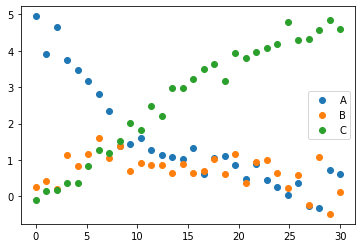

In [7]:
_ = plotData(OBS_TS)

# Bootstrapping Workflow

## Construct a good model.

First, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [8]:
FITTER = ModelFitter(MODEL, OBS_TS, parametersToFit=["k1", "k2"])
FITTER.fitModel()
FITTED_TS = FITTER.fittedTS
PARAMETER_ESTIMATES = FITTER.params
PARAMETER_ESTIMATES

name,value,initial value,min,max,vary
k1,0.10422066,0.06926458961073079,0.00000000,10.0000000,True
k2,0.20400499,9.133455318469242,0.00000000,10.0000000,True


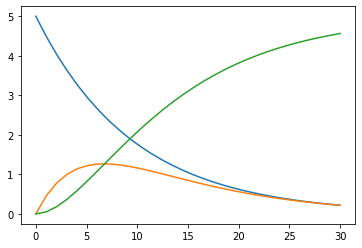

In [21]:

plt.plot(FITTED_TS["time"], FITTED_TS["A"])
plt.plot(FITTED_TS["time"], FITTED_TS["B"])
plt.plot(FITTED_TS["time"], FITTED_TS["C"])

In [9]:
print(FITTER.reportFit())

[[Variables]]
    k1:  0.10422065542003423
    k2:  0.204004991297852
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 90
    # variables        = 2
    chi-square         = 8.61006377
    reduced chi-square = 0.09784163
    Akaike info crit   = -207.219015
    Bayesian info crit = -202.219396
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.404


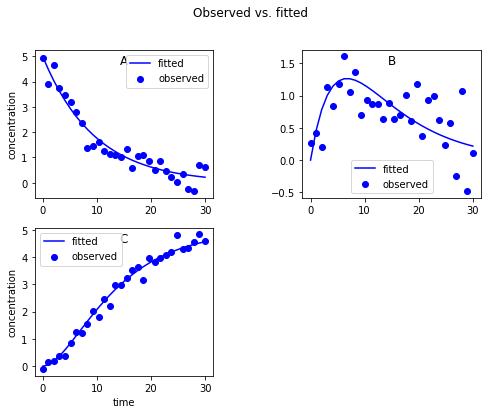

In [10]:
FITTER.plotFitAll()

**Question**
1. What are the parameter estimates if the NOSE_STD is 0.8?

## Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [11]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
columns = FITTED_TS.colnames
RESIDUALS_TS = OBS_TS.copy()  # Create the shape of the residuals
RESIDUALS_TS[columns] -= FITTED_TS[columns]
RESIDUALS_TS

                  A         B         C
time                                   
0.000000  -0.050328  0.262331 -0.103180
1.034483  -0.585231 -0.036460  0.096806
2.068966   0.636537 -0.584568  0.003708
3.103448   0.123764  0.122683 -0.015464
4.137931   0.219365 -0.303497 -0.234187
5.172414   0.261580 -0.052573 -0.019293
6.206897   0.190037  0.347315  0.143071
7.241379  -0.000560 -0.200681 -0.182811
8.275862  -0.723009  0.131601 -0.117716
9.310345  -0.443324 -0.494241  0.117512
10.344828 -0.090534 -0.215852 -0.334909
11.379310 -0.255087 -0.212266  0.089653
12.413793 -0.235633 -0.149710 -0.407723
13.448276 -0.145730 -0.312821  0.152493
14.482759 -0.089712  0.003111 -0.044294
15.517241  0.326325 -0.182791  0.037475
16.551724 -0.288799 -0.050555  0.152351
17.586207  0.254313  0.323067  0.122895
18.620690  0.397995 -0.020582 -0.477365
19.655172  0.209901  0.596450  0.176503
20.689655 -0.087690 -0.160907 -0.079252
21.724138  0.356481  0.459730 -0.035326
22.758621 -0.002952  0.559907 -0.008247


In [12]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(RESIDUALS_TS.flatten())

0.308981605493721

A validation of our codes and workflow is that the standard deviation of the residuals is close to the standard deviation of the noise used in the observational data.

## Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [13]:
synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=FITTED_TS, 
                                                        observedTS=OBS_TS)

In [14]:
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.356481  0.256234 -0.079252
1.034483   4.886966  0.462946 -0.426170
2.068966   4.240073  0.748725  0.106976
3.103448   3.828166  0.790587  0.527790
4.137931   2.643548  0.947034  0.641304
5.172414   2.742565  1.175530  0.776200
6.206897   2.742132  1.139350  1.438661
7.241379   2.748750  1.080443  1.705702
8.275862   2.320395  0.744844  1.547241
9.310345   2.301459  0.985169  1.997429
10.344828  1.920496  0.599849  2.307350
11.379310  1.781579  0.359867  2.542398
12.413793  1.020795  0.893843  2.931366
13.448276  1.637698  1.205969  2.411514
14.482759  1.102258  0.885364  2.965953
15.517241  0.387342  1.619411  3.112458
16.551724  0.745107  0.715576  3.360836
17.586207  0.625908  0.640327  3.661823
18.620690  0.113136  0.980305  3.633501
19.655172  1.051327  0.362742  3.929242
20.689655  0.135445  0.659401  3.558522
21.724138 -0.040735 -0.013632  4.319466
22.758621  1.103045  0.276050  4.630470


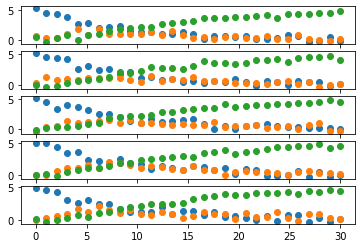

In [22]:
size = 5
fig, axes = plt.subplots(size)
for idx in range(size):
    ax = axes[idx]
    residualsTS = synthesizer.calculate()
    xvalues = residualsTS["time"]
    for col in residualsTS.colnames:
        ax.scatter(xvalues, residualsTS[col])

### Repeatedly estimate parameter values

In [23]:
def estimateParameters(model, observedTS, parametersToFit, numIteration=100):
    estimateDct = {p: [] for p in parametersToFit}
    # Get the initial estimates
    fitter = ModelFitter(model, observedTS, parametersToFit=parametersToFit)
    fitter.fitModel()
    initialParams = fitter.params
    # Create the observation synthesizer
    synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=fitter.fittedTS, observedTS=observedTS)
    # Iterative calculate parameters
    for _ in range(numIteration):
        newObservedTS = synthesizer.calculate()
        newFitter = ModelFitter(model, newObservedTS, parametersToFit=parametersToFit)
        newFitter.fitModel(params=initialParams)
        [estimateDct[p].append(newFitter.params.valuesdict()[p]) for p in parametersToFit]
    return estimateDct

# Tests
numIteration = 100
ESTIMATE_DCT = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
assert(len(ESTIMATE_DCT[PARAMETERS_TO_FIT[0]]) == len(ESTIMATE_DCT[PARAMETERS_TO_FIT[1]]))
assert(len(ESTIMATE_DCT[PARAMETERS_TO_FIT[0]]) == numIteration)

(0.0, 1.0)

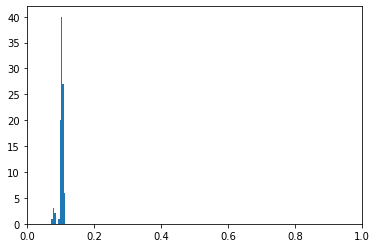

In [24]:
_ = plt.hist(ESTIMATE_DCT["k1"])
plt.xlim([0,1])

(0.0, 1.0)

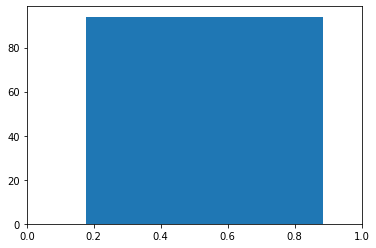

In [26]:
_ = plt.hist(ESTIMATE_DCT["k2"])
plt.xlim([0,1])

In [27]:
ESTIMATE_DCT["k2"]

[0.20632488888883915,
 0.20744344137137216,
 0.2129791722924057,
 0.21848244094509028,
 0.2153498026745443,
 0.2125181655443742,
 5.787273053905268,
 0.19472375883477389,
 0.20424019552422013,
 0.19970396597052797,
 0.21933848602798067,
 0.1909027173461042,
 0.19243551607909692,
 0.19201509708604458,
 0.21102936159369312,
 0.2095156474038573,
 0.21603229410823654,
 0.20620196534766932,
 0.1916619195590985,
 0.20037068652031753,
 0.1926484349693236,
 6.339567787980843,
 0.23046923516282902,
 0.2075344874536339,
 1.7997622847036938,
 0.20826744303834466,
 0.21633795129702316,
 0.20711027219239508,
 0.21245592472780073,
 0.19225555763365876,
 0.2278658098029368,
 0.1982126212861779,
 1.9102848412103712,
 0.19987003842331152,
 0.19280087755282782,
 0.17719987975766016,
 0.20042054782341445,
 0.19259326901380047,
 0.2110897782643073,
 0.24191913100879037,
 0.23020530790318738,
 0.1984786079508455,
 4.512117576626973,
 0.18542881156648539,
 0.20826680067221437,
 0.1987185976149658,
 0.215637

**Questions**
1. How do the quality of the parameter estimates change with the number of simulation points? With the simulation time?

## Compute Confidence Intervals

In [28]:
np.quantile(range(1000), [.10, .90])

array([ 99.9, 899.1])

In [31]:
np.quantile(ESTIMATE_DCT["k2"], [0.1, 0.9])

array([0.19204104, 0.2335463 ])

**Question**
1. Calculate 95% confidence intervals for the parameters.
   1. How many iterations should you use?

### Solution

In [ ]:
# Solution
for parameter in estimateDct.keys():
    quantile = np.quantile(estimateDct[parameter], [0.025, 0.975])
    print("%s: %s" % (parameter, str(quantile)))

**Questions**
1. Why does ``k1`` have such a wide confidence interval?

# Exercise

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.

In [ ]:
# Model used in this example
NEW_MODEL = """
     $A -> B; k1*$A
     $A -> C; k2*$A
     C -> D; k3*C
     D + B -> $E; k4*D*B
     
     A = 5;
     B = 10;
     C = 8;
     D = 4;
     E = 2
     k1 = 0.5
     k2 = 0.1
     k3 = 1.3;
     k4 = 1;
"""

In [ ]:
# Solution: Constants
NEW_NUM_POINT = 100
NEW_END_TIME = 5
NEW_NOISE_STD = 0.4

In [ ]:
# Plot of the ground truth model
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=0.4)
_ = plotData(synthesizer.calculate())

We are going to estimate the parameters ``k1``, ``k2``, ``k3``, and the constant value of ``A``.

In [ ]:
NEW_PARAMETERS_TO_FIT = ["k1", "k2", "k3", "A"]

## Generate randomized observations

**Question**
1. Generate data with 100 points over 30 s and a stardard deviation of 0.4.

In [ ]:
# Solution

fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NEW_NOISE_STD)
NEW_OBS_TS = synthesizer.calculate()
_ = plotData(NEW_OBS_TS)

**Questions**
1. For what part of these data will it be difficult to estimate the dynamics and therefore the kinetics constants?

## Construct a good fit of the model
**Question**
1. Find a good fit for the model.
1. How good are the estimates relative to ground truth? If there are bad estimates, explain why.
1. Plot the model using the estimated values.

In [ ]:
# Solution
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTED_TS = NEW_FITTER.fittedTS
NEW_PARAMETER_ESTIMATES = NEW_FITTER.params
print(NEW_FITTER.reportFit())

In [ ]:
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False, parameters=NEW_PARAMETER_ESTIMATES)
_ = plotData(fittedTS)

## Estimate the residuals

## Construct bootstrap estimates

# Bootstrapping With SBstoat

In [ ]:
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTER.bootstrap(numIteration=500, reportInterval=100)
print(NEW_FITTER.reportBootstrap())